In [68]:
import os
import sys
sys.path.insert(0, os.path.abspath('../model'))
import imp

import numpy as np
import networkx as nx
import json
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


from scipy.special import softmax
import scipy.stats as ss

import graph_manager
imp.reload(graph_manager)
import metrics
imp.reload(metrics)
import gridworld_environment
imp.reload(gridworld_environment)
import infoRL
imp.reload(infoRL)

<module 'infoRL' from '/Volumes/GoogleDrive/Altri computer/Il mio computer/GoogleDrive/Laboratorio/Humans account for cognitive costs when finding shortcuts/model/infoRL.py'>

In [69]:
H = graph_manager.load_graph(filename="map_low.json",filedir="../data/processed/")
old_coord2state = {(x,y):node for node,(x,y) in H.pos.items()}
G = graph_manager.load_graph(filename="map_high.json",filedir="../data/processed/")
coord2state = {(x,y):node for node,(x,y) in G.pos.items()}

In [70]:
with open('../data/processed/node_labels.json', 'r') as f:
    labels = json.load(f)

In [71]:
start_goal_positions = pd.read_csv("../data/processed/start_goal_positions.csv").set_index("dsp_goal")

In [73]:
DF = pd.read_csv("../data/processed/experiment2.csv",index_col=0)

DF.loc[DF.exp_type == 2,['x','y']] = DF.loc[DF.exp_type == 2,['y','x']].values
DF.loc[DF.exp_type == 2,['box_x','box_y']] = DF.loc[DF.exp_type == 2,['box_y','box_x']].values
DF = DF[~((DF.subject=="319_gtg_a1") & (DF.exp_type==2) & (DF.trial==20) & (DF.dsp_goal==13))]
states = DF.apply(lambda  row : labels[old_coord2state[row.box_x,row.box_y]], axis=1)
DF["state"] = states

In [74]:
default_policy = softmax(10*np.loadtxt("../data/processed/default_policy.txt"),axis=1)

In [ ]:
# Compute CI, number of steps etc for each subject for each trial

env = gridworld_environment.environment(G,0,0,diagonal_actions=False)
control_information_list = []
n_subjects = len(DF.subject.unique())
for s_number,subject in enumerate(DF.subject.unique()):
    print(f"{int(float(s_number)/n_subjects*100)}%",end="\r")
    _DF = DF[DF.subject == subject]
    for trial in _DF.trial.unique():
        __DF = _DF[_DF.trial == trial]
        if __DF.time.max() < 39.5:
            df = __DF[(__DF.subject == subject) & (__DF.trial == trial)]
            exp_type = df.exp_type.iloc[0]
            dsp_goal = df.dsp_goal.iloc[0]
            duration = df.time.iloc[-1]
            sequence = df.state.to_numpy()
            states_visited, actions = env.extract_states_and_actions(sequence)
            n_states_visited = len(states_visited)-1
            control_info, agent_policy = metrics.control_information_path(states_visited,default_policy,
                                    agent_actions=actions,beta=10.)
            control_information_list.append([subject,exp_type,trial,dsp_goal,duration,
                                            n_states_visited,control_info,
                                            states_visited,actions])

In [ ]:
CI_df = pd.DataFrame(control_information_list,columns=["subject","exp_type","trial","dsp_goal",
                            "duration","n_states_visited","control_info",
                            "states_visited","actions"])

In [75]:
#CI_df.to_excel("../data/processed/subjects_state_actions.xlsx")
CI_df = pd.read_excel("../data/processed/subjects_state_actions.xlsx")

In [21]:
# The same but for optimal artificial agents

th_curve = {}
for dsp in start_goal_positions.index:
    s_x, s_y, g_x, g_y = np.round(start_goal_positions.loc[dsp].to_numpy())
    start = labels[old_coord2state[s_x,s_y]]
    goal = labels[old_coord2state[g_x,g_y]]
    
    max_agent_iterations = 100
    control_infos = {}
    n_steps = {}
    env = gridworld_environment.environment(G,start,goal,diagonal_actions=False)
    #betas = [0.01,0.02,0.05,0.1,0.2,0.5,1,2,2.7,3,4,5,5.7,5.8,5.85,5.9,6,6.05,6.1,6.2,6.4,15,20,25,30,35]
    betas = np.round(np.logspace(np.log10(0.01), np.log10(35), num=20),decimals=3)
    
    for beta in betas:
        agent = infoRL.infoRL(beta,G,goal,default_policy=default_policy,F_threshold=0.0001,diagonal_actions=False)
        if np.isnan(agent.pi_s_a[0,0]):
            break
        control_infos[beta] = [] 
        n_steps[beta] = [] 
        for agent_iteration in range(max_agent_iterations):
            it = 0
            pos_history = []
            actions_history = []
            env.reset(start,goal)
            while env.agent != env.goal and it < 5000:
                it+=1
                pos_history.append(env.agent)
                action_id = random.choices(range(len(env.actions)),agent.pi_s_a[env.agent])[0]
                actions_history.append(action_id)
                env.step(action_id)
            pos_history.append(env.agent)
            if env.agent == env.goal:
                control_info, agent_policy = metrics.control_information_path(pos_history,
                                default_policy,agent_actions=actions_history, beta=10, diagonal_actions=False)
                control_infos[beta].append(control_info)
                n_steps[beta].append(it)
        control_infos[beta] = np.mean(control_infos[beta])
        n_steps[beta] = np.mean(n_steps[beta])
    
    th_curve[dsp] = {"ci" : control_infos,
                     "n_steps" : n_steps}
    print(dsp,end="\r")

In [77]:
#with open('../data/processed/theoretical_curves.json', 'w') as f:
#    json.dump(th_curve,f)
with open('../data/processed/theoretical_curves.json', 'r') as f:
    th_curve= json.load(f)

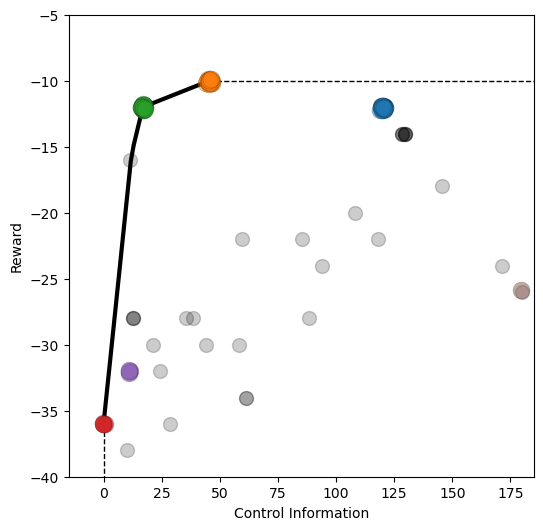

In [92]:
# plot figure 4A

extremes = [[110,125,10,15], [35,50,10,14], [10,25,10,15], [-5,5,35,40], [10,15,31,35], [175,190,25,30]]

dsp = str(6)
plt.figure(figsize=(6,6))


#plt.text(-45,-7,"A)",fontsize=20)

xs = list(th_curve[dsp]["ci"].values())
ys = -np.array(list(th_curve[dsp]["n_steps"].values()))
plt.plot(xs,ys,c="k",linewidth=3,zorder=0)
plt.plot([xs[-1],185],[ys[-1],ys[-1]],"--",c="k",linewidth=1,zorder=0)
plt.plot([xs[0],xs[0]],[ys[0],-40],"--",c="k",linewidth=1,zorder=0)

dsp = int(dsp)
row = (CI_df.dsp_goal==dsp)
xs = CI_df[row].control_info
ys = -CI_df[row].n_states_visited
plt.scatter(xs,ys,s=100,alpha=0.2,c="k",zorder=0)

for e in extremes:
    row = (  (CI_df.dsp_goal==dsp) 
           & (CI_df.control_info>=e[0]) & (CI_df.control_info<=e[1])
           & (CI_df.n_states_visited>=e[2]) & (CI_df.n_states_visited<=e[3])
           )

    xs = CI_df[row].control_info
    xs = xs + np.random.normal(0,0.5,size=len(xs))
    ys = -CI_df[row].n_states_visited 
    ys = ys + np.random.normal(0,0.1,size=len(ys))
    plt.scatter(xs,ys,s=150,alpha=0.5,edgecolors="k",linewidth=0.2,zorder=1)

plt.xlim([-15,185])
plt.ylim([-40,-5])
plt.ylabel("Reward")
plt.xlabel("Control Information")
#plt.title(f"DSP {dsp}")
#plt.tight_layout()
plt.savefig("out/Fig4_A.png",dpi=600)

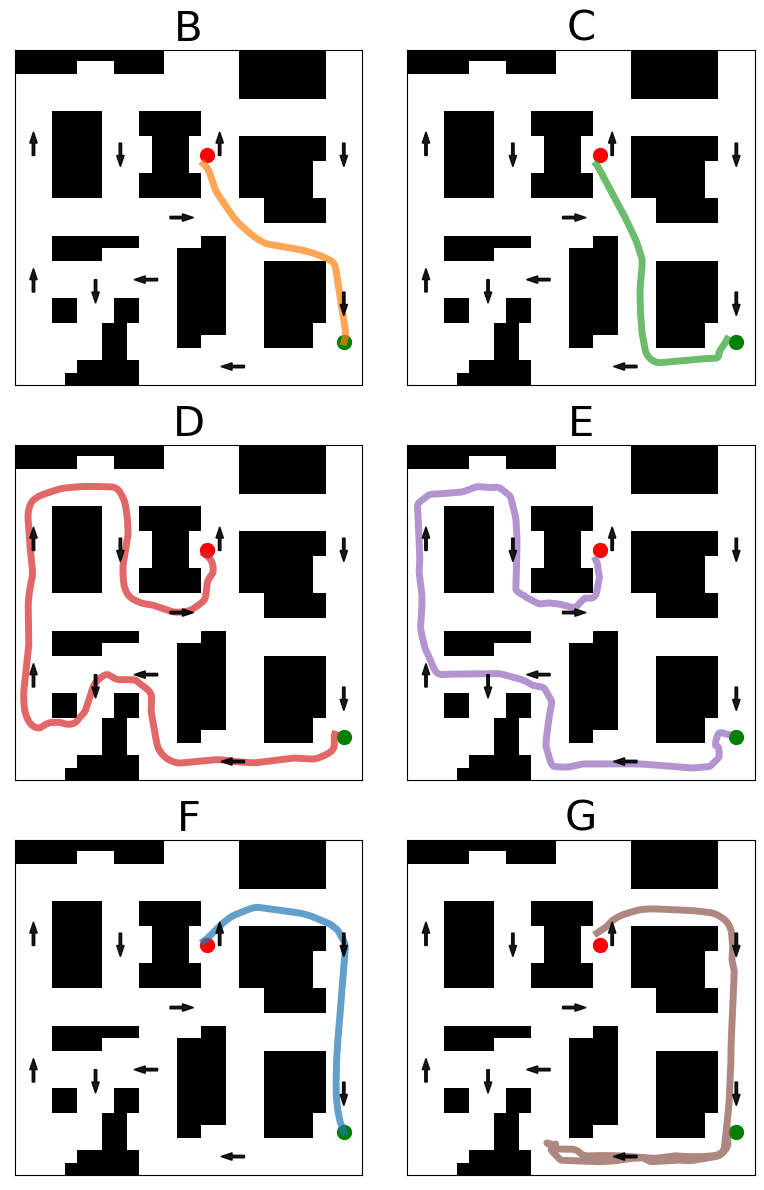

In [93]:
# plot figure 4B-G

xmax,ymax = max(list(H.pos.values()))
maze = np.ones((xmax+1,ymax+1))

for (x,y) in list(H.pos.values()):
    maze[x,y] = 0.
maze = np.array(maze)

dsp = 6
s_x, s_y, g_x, g_y = np.round(start_goal_positions.loc[dsp].to_numpy())


subjects = ["302_s_a","304_gtg_a","355_gtg_a","307_gtg_a","301_gtg_a","319_gtg_a1"]
colors = ["C1","C2","C3","C4","C0","C5"]
dp_arrows = [[2,8,0,1],[2,19,0,1],[9,20,0,-1],[13,14,1,0],[17,19,0,1],
            [27,20,0,-1],[27,8,0,-1],[19,2,-1,0],[12,9,-1,0],[7,9,0,-1]]

fig, axs = plt.subplots(3,2,figsize=(8,12))
axs = axs.flatten()
titles = "BCDEFG"
for i,ax in enumerate(axs):
    ax.imshow(maze.T,origin="lower",cmap="Greys",zorder=0)
    ax.set_xlim([0.5,28.5])
    ax.set_ylim([0.5,27.5])

    ax.scatter(s_x,s_y,c="green",s=100)
    ax.scatter(g_x,g_y,c="red",s=100)

    ax.set_title(titles[i], fontsize=30)
    df = DF[(DF.dsp_goal == dsp) & (DF.subject == subjects[i])]
    ax.plot(df.x/8.,df.y/8.,'-',alpha=0.7,linewidth=5,color=colors[i],
        markerfacecolor="k",zorder=1)

    for a in dp_arrows:
        ax.arrow(a[0],a[1],a[2],a[3],color="k",zorder=1,
                         length_includes_head=False,width=0.2, alpha=0.9)
    ax.set_xticks([])
    ax.set_yticks([])


plt.tight_layout()
plt.savefig("out/Fig4_BCDEFG.png", dpi=600)
plt.show()